In [101]:
import numpy as pyplot
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
import joblib

In [2]:
raw_data=pd.read_csv('train_V2.csv')
raw_data=raw_data.dropna(subset=['winPlacePerc'])

去除不重要的feature以及能判斷出類別的feature

In [3]:
raw_data=raw_data.drop(['Id', 'groupId', 'matchId', 'rankPoints', 'winPoints', 'killPoints', 'maxPlace', 'numGroups'] , axis=1)

In [4]:
raw_data.head()

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,kills,killStreaks,longestKill,...,matchType,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPlacePerc
0,0,0,0.00,0,0,0,60,0,0,0.00,...,squad-fpp,0,0.0000,0,0.00,0,0,244.80,1,0.4444
1,0,0,91.47,0,0,0,57,0,0,0.00,...,squad-fpp,0,0.0045,0,11.04,0,0,1434.00,5,0.6400
2,1,0,68.00,0,0,0,47,0,0,0.00,...,duo,0,0.0000,0,0.00,0,0,161.80,2,0.7755
3,0,0,32.90,0,0,0,75,0,0,0.00,...,squad-fpp,0,0.0000,0,0.00,0,0,202.70,3,0.1667
4,0,0,100.00,0,0,0,45,1,1,58.53,...,solo-fpp,0,0.0000,0,0.00,0,0,49.75,2,0.1875


In [5]:
raw_data.matchType.value_counts()

matchType
squad-fpp           1756186
duo-fpp              996691
squad                626526
solo-fpp             536761
duo                  313591
solo                 181943
normal-squad-fpp      17174
crashfpp               6287
normal-duo-fpp         5489
flaretpp               2505
normal-solo-fpp        1682
flarefpp                718
normal-squad            516
crashtpp                371
normal-solo             326
normal-duo              199
Name: count, dtype: int64

將類似的模式合併

In [6]:
raw_data['matchType']=raw_data['matchType'].replace({"normal-squad-fpp":"squad-fpp", "normal-duo-fpp":"duo-fpp", "normal-solo-fpp":"solo-fpp", "normal-squad":"squad", "normal-duo":"duo", "normal-solo":"solo", "crashfpp":"other", "flaretpp":"other", "flarefpp":"other", "crashtpp":"other"})
raw_data['matchType']=raw_data['matchType'].replace({'squad-fpp':'squad', 'duo-fpp':'duo', 'solo-fpp':'solo'})
raw_data.matchType.value_counts()

matchType
squad    2400402
duo      1315970
solo      720712
other       9881
Name: count, dtype: int64

In [48]:
raw_data[raw_data['matchType']=='solo'].max()

assists                 22
boosts                  28
damageDealt         6616.0
DBNOs                    0
headshotKills           42
heals                   63
killPlace              100
kills                   66
killStreaks             18
longestKill         1052.0
matchDuration         2237
matchType             solo
revives                  0
rideDistance       40710.0
roadKills               18
swimDistance        1974.0
teamKills                5
vehicleDestroys          5
walkDistance       25780.0
weaponsAcquired        153
winPlacePerc           1.0
dtype: object

資料分割 80%訓練 10%驗證 10%測試

In [7]:
from sklearn.model_selection import train_test_split
train, vt = train_test_split(raw_data, test_size=0.2, random_state=1)
valid, test = train_test_split(vt, test_size=0.5, random_state=1)

In [8]:
print("train:" + str(len(train)))
print("valid:" + str(len(valid)))
print("test:" + str(len(test)))

train:3557572
valid:444696
test:444697


In [9]:
train.matchType.value_counts()

matchType
squad    1920275
duo      1052871
solo      576546
other       7880
Name: count, dtype: int64

去除離群值

In [10]:
for feature in train.columns:
    if feature!="matchType":
        print(feature+":", end="")
        print(train[feature].quantile(0.9999))

assists:7.0
boosts:13.0
damageDealt:2196.4857999989763
DBNOs:15.0
headshotKills:9.0
heals:33.0
killPlace:100.0
kills:21.0
killStreaks:5.0
longestKill:686.6214499997441
matchDuration:2214.0
revives:5.0
rideDistance:15302.428999994881
roadKills:2.242899999488145
swimDistance:780.1
teamKills:3.0
vehicleDestroys:2.0
walkDistance:9098.242899999488
weaponsAcquired:39.0
winPlacePerc:1.0


In [11]:
max_outlier=['assists', 'boosts', 'damageDealt', 'DBNOs', 'headshotKills', 'heals', 'kills' ,'killStreaks', 'longestKill', 'matchDuration', 'revives', 'rideDistance', 'roadKills', 'swimDistance', 'teamKills', 'walkDistance', 'weaponsAcquired']
max_outlier_value=[]

for feature in max_outlier:
    max_outlier_value.append(train[feature].quantile(0.9999))

min_duration=train['matchDuration'].quantile(0.0001)


In [12]:
for feature in range(len(max_outlier)):
    train = train[train[max_outlier[feature]] <= max_outlier_value[feature]]
    train = train[train['matchDuration'] >= min_duration]

In [13]:
print("train:" + str(len(train)))
train.matchType.value_counts()

train:3552998


matchType
squad    1917820
duo      1052035
solo      575448
other       7695
Name: count, dtype: int64

平衡各資料與分出Y

In [16]:
train_drop=train.copy()
remove_counts = {'squad':917820, 'duo':52035}
for category, count in remove_counts.items():
    indices = train_drop[train_drop['matchType'] == category].sample(n=count, random_state=1).index
    train_drop = train_drop.drop(indices)

In [17]:
train_drop.matchType.value_counts()

matchType
squad    1000000
duo      1000000
solo      575448
other       7695
Name: count, dtype: int64

In [18]:
y_train_drop=train_drop['matchType'].copy()
x_train_drop=train_drop.drop('matchType', axis=1)
y_train=train['matchType'].copy()
x_train=train.drop('matchType', axis=1)
y_valid=valid['matchType'].copy()
x_valid=valid.drop('matchType', axis=1)
y_test=test['matchType'].copy()
x_test=test.drop('matchType', axis=1)

In [22]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(k_neighbors=3, random_state=1)
x_train_re, y_train_re = smote.fit_resample(x_train_drop, y_train_drop)

In [136]:
y_train_re.value_counts()

matchType
squad    1000000
duo      1000000
solo     1000000
other    1000000
Name: count, dtype: int64

In [31]:
x_train

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,kills,killStreaks,longestKill,matchDuration,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPlacePerc
135360,0,0,162.70,2,0,0,18,2,2,18.52,1253,0,0.0,0,0.0,0,0,227.100,2,0.3214
694120,1,0,29.18,0,0,0,60,0,0,0.00,1861,0,0.0,0,0.0,0,0,390.400,5,0.2963
2892339,2,3,283.40,1,1,2,10,2,1,34.91,1770,1,7596.0,0,0.0,0,0,2132.000,5,0.8889
2065958,0,0,75.78,0,0,0,84,0,0,0.00,1400,0,0.0,0,0.0,0,0,90.510,2,0.1064
2253202,0,1,20.40,0,0,2,57,0,0,0.00,1343,0,1068.0,0,0.0,0,0,792.100,2,0.6596
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1166159,0,2,0.00,0,0,0,60,0,0,0.00,1883,0,0.0,0,0.0,0,0,567.000,5,0.4615
4267654,0,0,293.90,2,1,0,31,1,1,44.27,1867,0,0.0,0,0.0,0,0,353.800,4,0.3488
491263,0,0,0.00,0,0,0,72,0,0,0.00,1409,0,0.0,0,0.0,0,0,234.700,2,0.2069
3937353,1,0,70.44,2,0,0,26,1,1,201.20,1337,0,0.0,0,0.0,0,0,1280.000,4,0.5926


決策樹

In [66]:
tree=DecisionTreeClassifier(random_state=1)
tree_grid=[{
    'min_samples_leaf':[2, 3, 5, 7, 9, 10, 15, 20, 25, 30]
}]

grid=GridSearchCV(tree, param_grid=tree_grid, scoring='accuracy', cv=5)


In [67]:
grid.fit(x_train, y_train)
print("best_param:")
print(grid.best_params_)
normal_tree=grid.best_estimator_
normal_tree.fit(x_train, y_train)

print("train_score:", end=" ")
print(normal_tree.score(x_train, y_train))
print("valid_score:", end=" ")
print(normal_tree.score(x_valid, y_valid))


best_param:
{'min_samples_leaf': 15}
train_score: 0.874032577558445
valid_score: 0.8294700199686977


In [102]:
joblib.dump(normal_tree, "classfier_decision_tree.pkl")

['classfier_decision_tree.pkl']

In [55]:
print("train_score:", end=" ")
print(normal_tree.score(x_train, y_train))
print("valid_score:", end=" ")
print(normal_tree.score(x_valid, y_valid))

train_score: 0.8874387207648301
valid_score: 0.8239921204598197


In [68]:
grid.fit(x_train_re, y_train_re)
print("best_param:")
print(grid.best_params_)
re_tree=grid.best_estimator_
re_tree.fit(x_train_re, y_train_re)

print("train_score:", end=" ")
print(re_tree.score(x_train_re, y_train_re))
print("valid_score:", end=" ")
print(re_tree.score(x_valid, y_valid))

best_param:
{'min_samples_leaf': 9}
train_score: 0.89268725
valid_score: 0.7546391242556713


In [56]:
print("train_score:", end=" ")
print(re_tree.score(x_train_re, y_train_re))
print("valid_score:", end=" ")
print(re_tree.score(x_valid, y_valid))

train_score: 0.88822375
valid_score: 0.7541601453577276


In [33]:
from sklearn.metrics import confusion_matrix

y_pred = tree.predict(x_valid)

label=['squad', 'duo', 'solo', 'other']
cm = confusion_matrix(y_valid, y_pred, labels=label)

# 3. 打印混淆矩陣
print("Confusion Matrix:")
print(pd.DataFrame(cm, index=label, columns=label))

Confusion Matrix:
        squad    duo   solo  other
squad  211393  24263   4558     40
duo     23749  97561   9971     12
solo     4935  13063  54109      2
other     308    102      8    622


In [42]:
valid_pred = pd.concat([x_valid, pd.DataFrame(y_pred, columns=['matchType'])], axis=1)
valid_pred[valid_pred['matchType']=='solo'].max()

assists                8.0
boosts                14.0
damageDealt         2348.0
DBNOs                 22.0
headshotKills         11.0
heals                 41.0
killPlace            100.0
kills                 27.0
killStreaks            6.0
longestKill          693.1
matchDuration       2200.0
revives                6.0
rideDistance       20510.0
roadKills              3.0
swimDistance         555.0
teamKills              3.0
vehicleDestroys        1.0
walkDistance        9315.0
weaponsAcquired       52.0
winPlacePerc           1.0
matchType             solo
dtype: object

隨機森林

樹數量

In [53]:
from sklearn.ensemble import RandomForestClassifier

rand1=RandomForestClassifier(n_estimators=100, max_samples=100000, min_samples_leaf=7, random_state=1)
rand2=RandomForestClassifier(n_estimators=500, max_samples=100000, min_samples_leaf=7, random_state=1)
rand3=RandomForestClassifier(n_estimators=1000, max_samples=100000, min_samples_leaf=7, random_state=1)
rand4=RandomForestClassifier(n_estimators=2000, max_samples=100000, min_samples_leaf=7, random_state=1)
re_rand1=RandomForestClassifier(n_estimators=100, max_samples=100000, min_samples_leaf=7, random_state=1)
re_rand2=RandomForestClassifier(n_estimators=500, max_samples=100000, min_samples_leaf=7, random_state=1)
re_rand3=RandomForestClassifier(n_estimators=1000, max_samples=100000, min_samples_leaf=7, random_state=1)
re_rand4=RandomForestClassifier(n_estimators=2000, max_samples=100000, min_samples_leaf=7, random_state=1)

In [54]:
print("樹數量測試")
print("------normal------")

rand1.fit(x_train, y_train)
print("n=100")
print(rand1.score(x_train, y_train))
print(rand1.score(x_valid, y_valid), end="\n")

rand2.fit(x_train, y_train)
print("n=500")
print(rand2.score(x_train, y_train))
print(rand2.score(x_valid, y_valid), end="\n")

rand3.fit(x_train, y_train)
print("n=1000")
print(rand3.score(x_train, y_train))
print(rand3.score(x_valid, y_valid), end="\n")

rand4.fit(x_train, y_train)
print("n=2000")
print(rand4.score(x_train, y_train))
print(rand4.score(x_valid, y_valid), end="\n")

print("------re------")

re_rand1.fit(x_train_re, y_train_re)
print("n=100")
print(re_rand1.score(x_train_re, y_train_re))
print(re_rand1.score(x_valid, y_valid), end="\n")

re_rand2.fit(x_train_re, y_train_re)
print("n=500")
print(re_rand2.score(x_train_re, y_train_re))
print(re_rand2.score(x_valid, y_valid), end="\n")

re_rand3.fit(x_train_re, y_train_re)
print("n=1000")
print(re_rand3.score(x_train_re, y_train_re))
print(re_rand3.score(x_valid, y_valid), end="\n")

re_rand4.fit(x_train_re, y_train_re)
print("n=2000")
print(re_rand4.score(x_train_re, y_train_re))
print(re_rand4.score(x_valid, y_valid), end="\n")

樹數量測試
------normal------
n=100
0.6958610728179414
0.6914498893626208
n=500
0.6982359686101709
0.6936041700397575
n=1000
0.6985461292125692
0.6938177991256949
n=2000
0.6990316346927299
0.6941191285732276
------re------
n=100
0.74507775
0.6419891341500711
n=500
0.74707475
0.6443188155503985
n=1000
0.74747225
0.64461339881627
n=2000
0.74746975
0.6444290031841977


樣本數

In [63]:
sample_rand1=RandomForestClassifier(n_estimators=500, max_samples=50000, min_samples_leaf=7, random_state=1)
sample_rand2=RandomForestClassifier(n_estimators=500, max_samples=100000, min_samples_leaf=7, random_state=1)
sample_rand3=RandomForestClassifier(n_estimators=500, max_samples=500000, min_samples_leaf=7, random_state=1)
sample_rand4=RandomForestClassifier(n_estimators=500, max_samples=1000000, min_samples_leaf=7, random_state=1)
sample_re_rand1=RandomForestClassifier(n_estimators=500, max_samples=50000, min_samples_leaf=7, random_state=1)
sample_re_rand2=RandomForestClassifier(n_estimators=500, max_samples=100000, min_samples_leaf=7, random_state=1)
sample_re_rand3=RandomForestClassifier(n_estimators=500, max_samples=500000, min_samples_leaf=7, random_state=1)
sample_re_rand4=RandomForestClassifier(n_estimators=500, max_samples=1000000, min_samples_leaf=7, random_state=1)

In [64]:
print("樣本測試")
print("------normal------")

sample_rand1.fit(x_train, y_train)
print("n=50000")
print(sample_rand1.score(x_train, y_train))
print(sample_rand1.score(x_valid, y_valid), end="\n")

sample_rand2.fit(x_train, y_train)
print("n=100000")
print(sample_rand2.score(x_train, y_train))
print(sample_rand2.score(x_valid, y_valid), end="\n")

sample_rand3.fit(x_train, y_train)
print("n=500000")
print(sample_rand3.score(x_train, y_train))
print(sample_rand3.score(x_valid, y_valid), end="\n")

sample_rand4.fit(x_train, y_train)
print("n=1000000")
print(sample_rand4.score(x_train, y_train))
print(sample_rand4.score(x_valid, y_valid), end="\n")

print("------re------")

sample_re_rand1.fit(x_train_re, y_train_re)
print("n=50000")
print(sample_re_rand1.score(x_train_re, y_train_re))
print(sample_re_rand1.score(x_valid, y_valid), end="\n")

sample_re_rand2.fit(x_train_re, y_train_re)
print("n=100000")
print(sample_re_rand2.score(x_train_re, y_train_re))
print(sample_re_rand2.score(x_valid, y_valid), end="\n")

sample_re_rand3.fit(x_train_re, y_train_re)
print("n=500000")
print(sample_re_rand3.score(x_train_re, y_train_re))
print(sample_re_rand3.score(x_valid, y_valid), end="\n")

sample_re_rand4.fit(x_train_re, y_train_re)
print("n=1000000")
print(sample_re_rand4.score(x_train_re, y_train_re))
print(sample_re_rand4.score(x_valid, y_valid), end="\n")

樣本測試
------normal------
n=50000
0.6858253227274544
0.6839076582654218
n=100000
0.6982359686101709
0.6936041700397575
n=500000
0.7365979378541727
0.715376346987605
n=1000000
0.760730234016456
0.7224845737312681
------re------
n=50000
0.733323
0.6360390019249105
n=100000
0.74707475
0.6443188155503985
n=500000
0.78680425
0.6659043481389534
n=1000000
0.80797625
0.6748407901127962


In [69]:
sample_rand5=RandomForestClassifier(n_estimators=500, max_samples=2000000, min_samples_leaf=7, random_state=1)

In [70]:
sample_rand5.fit(x_train, y_train)
print("n=2000000")
print(sample_rand5.score(x_train, y_train))
print(sample_rand5.score(x_valid, y_valid), end="\n")

n=2000000
0.7926033169734404
0.7293094608451617


sample leaf

In [83]:
leaf_rand1=RandomForestClassifier(n_estimators=500, max_samples=1000000, min_samples_leaf=5, random_state=1)
leaf_rand2=RandomForestClassifier(n_estimators=500, max_samples=1000000, min_samples_leaf=7, random_state=1)
leaf_rand3=RandomForestClassifier(n_estimators=500, max_samples=1000000, min_samples_leaf=10, random_state=1)
leaf_rand4=RandomForestClassifier(n_estimators=500, max_samples=1000000, min_samples_leaf=15, random_state=1)
leaf_rand5=RandomForestClassifier(n_estimators=500, max_samples=1000000, min_samples_leaf=20, random_state=1)

In [84]:
print("最小葉節點內sample數")
leaf_rand1.fit(x_train, y_train)
print("n=5")
print(leaf_rand1.score(x_train, y_train))
print(leaf_rand1.score(x_valid, y_valid), end="\n")

leaf_rand2.fit(x_train, y_train)
print("n=7")
print(leaf_rand2.score(x_train, y_train))
print(leaf_rand2.score(x_valid, y_valid), end="\n")

leaf_rand3.fit(x_train, y_train)
print("n=10")
print(leaf_rand3.score(x_train, y_train))
print(leaf_rand3.score(x_valid, y_valid), end="\n")

leaf_rand4.fit(x_train, y_train)
print("n=15")
print(leaf_rand4.score(x_train, y_train))
print(leaf_rand4.score(x_valid, y_valid), end="\n")

leaf_rand5.fit(x_train, y_train)
print("n=20")
print(leaf_rand5.score(x_train, y_train))
print(leaf_rand5.score(x_valid, y_valid), end="\n")

最小葉節點內sample數
n=5
0.7775453293246999
0.7264243438213971
n=7
0.760730234016456
0.7224845737312681
n=10
0.7457721619882702
0.7183716516451688
n=15
0.7318098687362053
0.7124642452371958
n=20
0.723215436653778
0.7082883587889255


阿搭布斯特

In [85]:
ada_tree=DecisionTreeClassifier(max_depth=10, random_state=1)
ada=AdaBoostClassifier(ada_tree, n_estimators=1000, random_state=1)


In [86]:
ada.fit(x_train, y_train)
print("adaboost")
print(ada.score(x_train, y_train))
print(ada.score(x_valid, y_valid), end="\n")

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


adaboost
0.6745660988269625
0.6680878622699552


score

In [98]:
def caculate_score(model, x, y):
    y_pred=model.predict(x)
    accuracy = accuracy_score(y, y_pred) 
    f1_weighted = f1_score(y, y_pred, average='weighted')
    print("accuracy:",end="")
    print(accuracy)
    print("f1 score:", end="")
    print(f1_weighted, end="\n")

In [99]:
print("決策樹")
caculate_score(normal_tree, x_valid, y_valid)
print("隨機森林")
caculate_score(leaf_rand1, x_valid, y_valid)
print("adaboost")
caculate_score(ada, x_valid, y_valid)

決策樹
accuracy:0.8294700199686977
f1 score:0.8286023038451655
隨機森林
accuracy:0.7264243438213971
f1 score:0.7097229499680151
adaboost
accuracy:0.6680878622699552
f1 score:0.6355624443911883


solo補正

In [93]:
train_multi=train[train['matchType'] != 'solo']
valid_multi=valid[valid['matchType'] != 'solo']
y_train_multi=train_multi['matchType'].copy()
x_train_multi=train_multi.drop('matchType', axis=1)
y_valid_multi=valid_multi['matchType'].copy()
x_valid_multi=valid_multi.drop('matchType', axis=1)

train_multi.matchType.value_counts()


matchType
squad    1917820
duo      1052035
other       7695
Name: count, dtype: int64

In [90]:
tree_multi=DecisionTreeClassifier(random_state=1)
tree_grid_multi=[{
    'min_samples_leaf':[2, 3, 5, 7, 9, 10, 13, 15, 17, 20, 25, 30]
}]

grid_multi=GridSearchCV(tree_multi, param_grid=tree_grid_multi, scoring='accuracy', cv=5)

In [92]:
grid_multi.fit(x_train_multi, y_train_multi)
print("best_param:")
print(grid_multi.best_params_)
multi_tree=grid.best_estimator_
multi_tree.fit(x_train_multi, y_train_multi)

print("train_score:", end=" ")
print(multi_tree.score(x_train_multi, y_train_multi))

best_param:
{'min_samples_leaf': 25}
train_score: 0.9349827878625044


In [94]:
print("valid_score:", end=" ")
print(multi_tree.score(x_valid_multi, y_valid_multi))

valid_score: 0.8910616849219108


最終模型

In [139]:
output=normal_tree.predict(x_test)


In [131]:
X_with_pred = x_valid.assign(predicted=output)
X_with_pred

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,kills,killStreaks,longestKill,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPlacePerc,predicted
121605,0,0,0.00,0,0,0,95,0,0,0.000,...,0,0.0,0,0.0,0,0,36.96,1,0.0208,duo
2588043,0,0,100.00,1,0,0,44,1,1,5.282,...,0,0.0,0,0.0,0,0,180.40,2,0.3125,duo
3410158,3,0,123.40,0,0,0,78,0,0,0.000,...,0,0.0,0,0.0,0,0,158.40,1,0.1481,squad
2072022,1,0,0.00,0,0,0,61,0,0,0.000,...,0,0.0,0,0.0,0,0,646.30,3,0.3846,squad
2956261,0,0,40.64,0,0,0,67,0,0,0.000,...,1,0.0,0,0.0,0,0,146.50,1,0.2444,duo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427997,1,4,420.50,2,0,2,14,2,1,218.300,...,1,1981.0,0,0.0,0,0,2729.00,8,0.7857,squad
1296990,0,0,100.00,1,1,0,42,1,1,9.865,...,0,0.0,0,0.0,0,0,146.20,2,0.1875,duo
3369016,0,0,121.60,1,0,0,22,2,2,9.989,...,0,0.0,0,0.0,0,0,145.20,3,0.1429,duo
70941,0,0,0.00,0,0,0,92,0,0,0.000,...,0,0.0,0,0.0,0,0,0.00,0,0.0000,squad


In [135]:
print(X_with_pred[X_with_pred["predicted"]=="solo"]['revives'].value_counts())

revives
0    66867
1        5
Name: count, dtype: int64


In [143]:
count=0
for i in range(len(output)):
    if output[i]=="solo" and (x_test.iloc[i]["DBNOs"]!=0 or x_test.iloc[i]["revives"]!=0):
       count+=1
print("must not be solo count:")
print(count) 

must not be solo count:
3


In [140]:
caculate_score(normal_tree, x_test, y_test)



accuracy:0.8298841683213514
f1 score:0.82900859113023


In [124]:
x_valid.iloc[2]["DBNOs"]!=0

False

In [126]:
import numpy as np
from sklearn.metrics import confusion_matrix

# 假設多分類問題
y_true = [2, 0, 2, 2, 0, 1, 1, 2, 0, 1]
y_pred = [0, 0, 2, 2, 0, 2, 1, 2, 0, 2]

# 顯式指定類別標籤
labels = ["squad", "duo", "solo", "other"]
cm = confusion_matrix(y_valid, output, labels=labels)

cm_df = pd.DataFrame(cm, index=labels, columns=labels)

print("Confusion Matrix with Labels:")
print(cm_df)

Confusion Matrix with Labels:
        squad    duo   solo  other
squad  216288  19795   4156     15
duo     25223  97658   8406      6
solo     5127  12670  54306      6
other     320    106      4    610


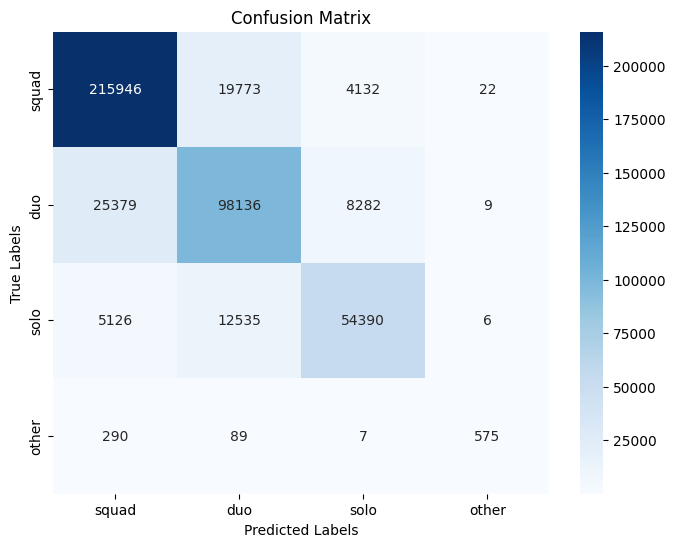

In [142]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 顯式指定類別標籤
labels = ["squad", "duo", "solo", "other"]
cm = confusion_matrix(y_test, output, labels=labels)  # 確保與類別索引對應

# 創建 DataFrame
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

# 視覺化混淆矩陣
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()